Salem Ameen, PhD student at Salford University

### Parkinsons Telemonitoring Data Set

Decision trees Regression

# Import the Libraries

In [1]:
import numpy as np
import pandas
from numpy import *
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics, grid_search, cross_validation
from IPython.display import set_matplotlib_formats
from bokeh.plotting import figure, show, output_notebook
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from bokeh.layouts import gridplot
output_notebook()
set_matplotlib_formats('png', 'pdf')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

Loading BokehJS ...

# Load data

In the previous file we have not change the data as there is no missing value or add any new parameters so it can be downloaded from the web directly. 

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data'
data = pd.read_csv(url)
M_UPDRS = data['motor_UPDRS']
data = data.drop('motor_UPDRS', 1)
data = data.drop('total_UPDRS', 1)
from sklearn import preprocessing
dataset = data.values
X = dataset[:,0:20].astype(float)
Y = M_UPDRS.values
MEDV = M_UPDRS
feature_cols = list(data.columns.values)
print 'Number of examples',len(X)

Number of examples 5875


In [3]:
# Make developement dataset for genrilization and final testing
from sklearn.cross_validation import train_test_split
# Extracting 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=0)
X = X_train
Y = y_train
new_data      = X_train
new_test_data = X_test
print 'Number of training examples',len(X_train)
print 'Number of validation examples',len(X_test)

Number of training examples 4700
Number of validation examples 1175


Number of training data is very small so we need to use cross validation instead of spareate another validation data.

From the previous visulization the data has no missing value but has many outlier and some sparisty

# Set the parameters for cross validation

In [4]:
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

 # Set the parameters for bias-variance dilemma

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Preprocessing the data and save both the model and preprocessed data

In [6]:
# According to the nature of the data spasity and there is outliter RobustScaler class is recomandit 
# but when I tried both of them the result seems is same
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train)

In [7]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # use same transform for testing data
X = X_train

In [8]:
# save transformed data
np.save('./data/X_train', X_train)
np.save('./data/y_train', y_train)
np.save('./data/X_test', X_test)
np.save('./data/y_test', y_test)

In [9]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(scaler, 'scaler.pkl') 

['scaler.pkl', 'scaler.pkl_01.npy', 'scaler.pkl_02.npy', 'scaler.pkl_03.npy']

In [10]:
# Test the model if it is work
scalerTest = joblib.load('scaler.pkl')
new_data_scaled = scalerTest.transform(new_test_data)
print " =================================================================>>>>> done"
print new_data_scaled

 =================================================================>>>>> done
[[ 1.56638181  0.35745305  1.45347266 ...,  0.10654841  0.65433521
   0.34236736]
 [ 1.08416036  0.69933936 -0.68800744 ...,  1.03217561  1.35448669
   2.09798914]
 [ 0.11971746 -0.66820588  1.45347266 ..., -0.37688437  0.55760283
  -0.48973219]
 ..., 
 [ 1.56638181  0.35745305  1.45347266 ...,  1.28447486 -0.04104284
   0.85186293]
 [-1.24657665 -0.21235747 -0.68800744 ...,  0.08110981 -0.87695661
   0.46320715]
 [ 0.11971746 -0.66820588  1.45347266 ...,  0.38418689  0.68227388
   0.30398295]]


# 1. DecisionTreeRegressor  with   Regression

Decision trees or the Classification and Regression Trees (CART as they are know) use the training data to select the best points to split the data in order to minimize a cost metric. The default cost metric for regression decision trees is the mean squared error, specified in the criterion parameter.

## Validation curve

choosing multiple hyperparameters of an estimator 

In [11]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor()
estimator.get_params().keys()

['presort',
 'splitter',
 'max_leaf_nodes',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'criterion',
 'random_state',
 'max_features',
 'max_depth']

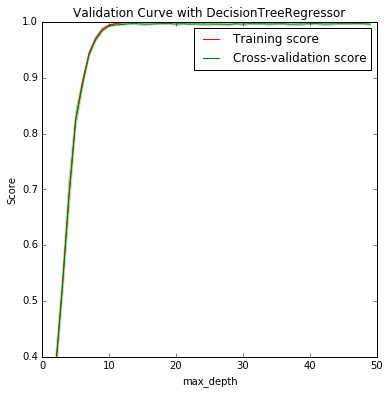

In [12]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.linspace(1,50,100)
param_range = np.arange(1,50) # generate integer numbers

train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(), X, Y, param_name="max_depth", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DecisionTreeRegressor")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

more that 5 is the best of number of K

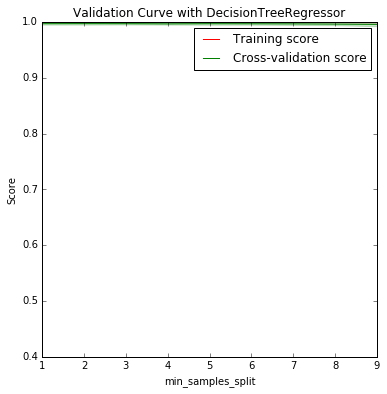

In [13]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.linspace(1,50,100)
param_range = np.arange(1,10) # generate integer numbers

train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(), X, Y, param_name="min_samples_split", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DecisionTreeRegressor")
plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

min_samples_split =2 (The defualt) is the best

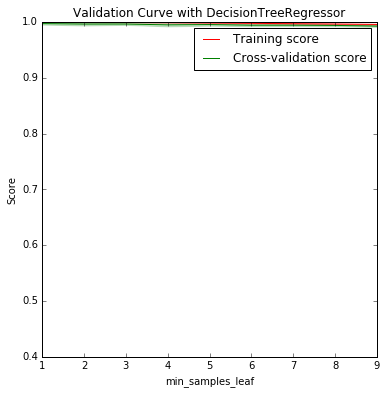

In [14]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.linspace(1,50,100)
param_range = np.arange(1,10) # generate integer numbers

train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(), X, Y, param_name="min_samples_leaf", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DecisionTreeRegressor")
plt.xlabel("min_samples_leaf")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

min_samples_leaf = 2 is the best

## Grid search and/or Random search to determine best compination of parameters

In [15]:
# Utility function to report optimal parameters
from operator import itemgetter
def report(grid_scores, n_top=5):
    params = None
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Parameters with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
              score.mean_validation_score, np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if params == None:
            params = score.parameters
    
    return params

# The most common value for the max number of features to look at in each split is sqrt(# of features)
sqrtfeat = np.sqrt(X.shape[1]) 
grid_test1 = { "max_depth"      : np.arange(1,15),
             "min_samples_split"      : np.arange(1,4),
             "min_samples_leaf"    : np.arange(1,3)}

# Large randomized test using max_depth to control tree size (5000 possible combinations)
random_test1 = { "max_depth"      : [1,10],
                "min_samples_split"      : [ 1,2],
               "min_samples_leaf"   : [1,2]}


forest =  DecisionTreeRegressor()

print "Hyperparameter optimization using GridSearchCV..."
grid_search = GridSearchCV(forest, grid_test1, n_jobs=-1, cv=num_folds)
grid_search.fit(X, Y)
best_params_from_grid_search = report(grid_search.grid_scores_)
print '+++++++++++++++++++++++++++++++++++++++++++++++'
print "Hyperparameter optimization using RandomizedSearchCV"
grid_search = RandomizedSearchCV(forest, random_test1, n_jobs=-1, cv=num_folds, n_iter=5)
grid_search.fit(X, Y)
best_params_from_rand_search1 = report(grid_search.grid_scores_)

Hyperparameter optimization using GridSearchCV...
Parameters with rank: 1
Mean validation score: 0.9971 (std: 0.0012)
Parameters: {'min_samples_split': 3, 'max_depth': 13, 'min_samples_leaf': 1}

Parameters with rank: 2
Mean validation score: 0.9971 (std: 0.0017)
Parameters: {'min_samples_split': 2, 'max_depth': 14, 'min_samples_leaf': 1}

Parameters with rank: 3
Mean validation score: 0.9971 (std: 0.0014)
Parameters: {'min_samples_split': 2, 'max_depth': 14, 'min_samples_leaf': 2}

Parameters with rank: 4
Mean validation score: 0.9971 (std: 0.0015)
Parameters: {'min_samples_split': 3, 'max_depth': 14, 'min_samples_leaf': 1}

Parameters with rank: 5
Mean validation score: 0.9970 (std: 0.0015)
Parameters: {'min_samples_split': 2, 'max_depth': 13, 'min_samples_leaf': 1}

+++++++++++++++++++++++++++++++++++++++++++++++
Hyperparameter optimization using RandomizedSearchCV
Parameters with rank: 1
Mean validation score: 0.9930 (std: 0.0013)
Parameters: {'min_samples_split': 1, 'max_depth': 1

Best 'min_samples_split': 3, 'max_depth': 7, 'min_samples_leaf': 1

## Learning Curve 

In essence, what we’re doing it training the exact same model with increasingly large fractions of our total training data, and plotting the error of the training and test sets at each step.

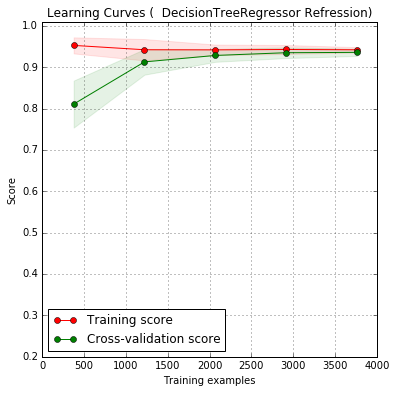

In [16]:
from sklearn.tree import DecisionTreeRegressor

model =  DecisionTreeRegressor(min_samples_split = 3, max_depth = 7, min_samples_leaf =1 )
title = "Learning Curves (  DecisionTreeRegressor Refression)"
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.2, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [17]:
# More data from learning curve to show the process of building the model
train_sizes, train_scores, valid_scores = learning_curve(
     model, X, Y, train_sizes=[50, 80, 110], cv=cv, n_jobs=4)

print 'train_sizes = ', train_sizes

print ' training scores'
print ' 50 training sizees'
print train_scores[0].mean(),'±',train_scores[0].std()
print ' 80 training sizees'
print train_scores[1].mean(),'±',train_scores[1].std()
print ' 110 training sizees'
print train_scores[2].mean(),'±',train_scores[2].std()

print '\n validation scores'
print ' 50 validation scores'
print valid_scores[0].mean(),'±',valid_scores[0].std()
print ' 80 validation scores'
print valid_scores[1].mean(),'±',valid_scores[1].std()
print ' 110 validation scores'
print valid_scores[2].mean(),'±',valid_scores[2].std()

train_sizes =  [ 50  80 110]
 training scores
 50 training sizees
0.983882261083 ± 0.0192316003708
 80 training sizees
0.981755882126 ± 0.0147166070998
 110 training sizees
0.96933955957 ± 0.0335785454218

 validation scores
 50 validation scores
-0.133042092531 ± 0.242660208131
 80 validation scores
0.112831222967 ± 0.204220942531
 110 validation scores
0.296368772386 ± 0.172015915511


## Cross validation

In [18]:
scoring = 'mean_squared_error'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
## Fit the model
model.fit(X,Y)


Scoring according to mean_squared_error
[-3.25639002 -4.49121994 -3.48764311 -3.46561408 -3.98702597 -3.68512739
 -4.0276861  -3.56169534 -4.89206088 -4.22298775]

 Mean      Standard deviation
-3.91      0.49


DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

## Coefficients Of Determination {Calculating R^2}

R^2, Close to one is better

In [19]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
r_squared = r2_score(Y, predicted, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.94101531054


## Residual Plot

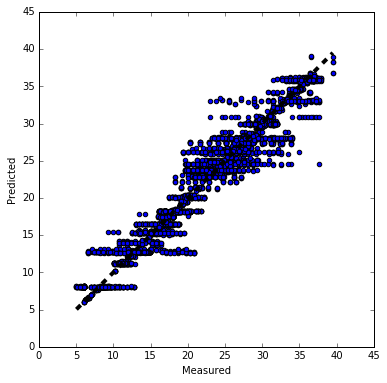

In [20]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [21]:
# Plotining using bokeh
#TOOLS = [BoxSelectTool(), HoverTool()]
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,DecisionTreeRegressor_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, tools=TOOLS)
p.scatter(Y, predicted,x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Measured"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Predicted"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, color='red')

# create a new plot with the toolbar below
# line_dash="4 4", line_width=2, color='red'
p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, line_color="black")
show(p)

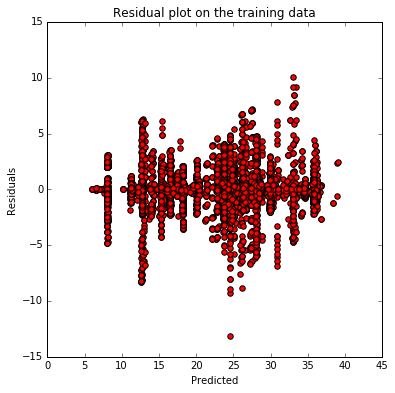

In [22]:
plt.scatter(predicted, (predicted - Y), c='r', s=30)
plt.title("Residual plot on the training data")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

In [23]:
# Plotining using bokeh
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,DecisionTreeRegressor_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, title="Residual plot on the training data", tools=TOOLS)
p.scatter(predicted, (predicted - Y),x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Predicted"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Residuals"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([2,38], [0, 0], line_dash="4 4", line_width=2, color='red')
show(p)

## Pipeline

The best to deliver the model by pipeline the operation then at deployment can be done in one model.

  I used two ways to check the pipeline so any one can be fine

In [24]:
# Use Pipeline
# ANOVA 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
anova_filter = SelectKBest(f_regression, k=13)
LR =  DecisionTreeRegressor(min_samples_split = 3, max_depth = 7, min_samples_leaf =1 )

anova_LinReg = Pipeline([('scaler_Input',scaler), ('anova', anova_filter), ('LinReg', LR)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
anova_LinReg.set_params(anova__k=13).fit(new_data, Y)
prediction = anova_LinReg.predict(new_data)
print anova_LinReg.score(new_data, Y)                        
# getting the selected features chosen by anova_filter
results = cross_validation.cross_val_score(anova_LinReg, new_data, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
print anova_LinReg.named_steps['anova'].get_support()
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

0.923736691411
Scoring according to mean_squared_error
[-6.54352885 -6.54050598 -5.6341785  -5.85558021 -6.33286256 -6.00686221
 -6.29010249 -5.93816837 -4.77162558 -6.43260482]

 Mean      Standard deviation
-6.03      0.51
[ True  True False False  True False False False False  True  True  True
  True  True  True False  True  True  True  True]
R-squared =  0.923736691411


In [25]:
# Using make_pipeline
from sklearn.pipeline import make_pipeline

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=13)
anova_DTRegressor = make_pipeline(scaler, anova_filter, LR)
anova_DTRegressor.fit(new_data, Y)
prediction = anova_DTRegressor.predict(new_data)
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.923736691411


### Save the Pipeline model for developement

In [26]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(anova_DTRegressor, 'anova_DTRegressor.pkl') 

['anova_DTRegressor.pkl',
 'anova_DTRegressor.pkl_01.npy',
 'anova_DTRegressor.pkl_02.npy',
 'anova_DTRegressor.pkl_03.npy',
 'anova_DTRegressor.pkl_04.npy',
 'anova_DTRegressor.pkl_05.npy',
 'anova_DTRegressor.pkl_06.npy',
 'anova_DTRegressor.pkl_07.npy',
 'anova_DTRegressor.pkl_08.npy']

In [27]:
# Test the model if it is work
anova_DecisionTreeRegressorTest = joblib.load('anova_DTRegressor.pkl')
NewPred = anova_DecisionTreeRegressorTest.predict(new_data)
print " =================================================================>>>>> done"
r_squared = r2_score(Y, NewPred, multioutput='variance_weighted')
print 'R-squared = ',r_squared

 =================================================================>>>>> done
R-squared =  0.923736691411


In [28]:
# test on single data point, randomly choose point number 55
print 'Point of training data before normalization\n',new_data[55]
print '\nThe read target of the data = ', Y[55]
NewPred = anova_DecisionTreeRegressorTest.predict([new_data[55]])
print '\nThe Predicted target of the data = ', NewPred

Point of training data before normalization
[  2.60000000e+01   4.90000000e+01   0.00000000e+00   3.17820000e+01
   1.18000000e-02   1.27000000e-04   7.05000000e-03   6.00000000e-03
   2.11500000e-02   5.81300000e-02   5.27000000e-01   3.21500000e-02
   3.45600000e-02   4.39900000e-02   9.64400000e-02   3.43700000e-02
   1.74210000e+01   6.30040000e-01   7.72870000e-01   4.15090000e-01]

The read target of the data =  25.706

The Predicted target of the data =  [ 25.28646316]


## Conclusion 